# Probe for Precip, Q, etc.

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

### Get the cell state data

In [8]:
from scripts.cell_state.extract_cell_state import get_cell_states
from scripts.cell_state.normalize import (normalize_xarray_cstate, normalize_xr_by_basin)
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable
from scripts.cell_state.cell_state_dataset import fill_gaps
from scripts.cell_state.normalize import normalize_2d_dataset


data_dir = Path("/datadrive/data/")

if not (data_dir / "SOIL_MOISTURE/norm_cs_data.nc").exists():
    out_dir = run_dir / "cell_states"
    if not out_dir.exists():
        out_dir.mkdir(parents=True, exist_ok=True)

    if not (out_dir / "cell_states.nc").exists():
        cn = get_cell_states(cfg, run_dir)
        cn.to_netcdf(out_dir / "cell_states.nc")
    else:
        cn = xr.open_dataset(out_dir / "cell_states.nc")

    cs_data = cn.copy()
    norm_cs_data = normalize_xarray_cstate(cs_data, cell_state_var="c_n")

    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data.nc")
    

cs = dataset_dimensions_to_variable(norm_cs_data)

## Load the camels data

In [3]:
# Load the discharge data to be the 
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

In [30]:
epsilon = 1e-10
log_pcp = np.log(ds["precipitation"] + epsilon)

norm_log_pcp = normalize_2d_dataset(log_pcp.to_dataset(), variable_str="precipitation")

norm_temp = normalize_2d_dataset(ds[["temperature"]], variable_str="temperature")

Normalising each station: 100%|██████████| 671/671 [00:09<00:00, 73.98it/s]


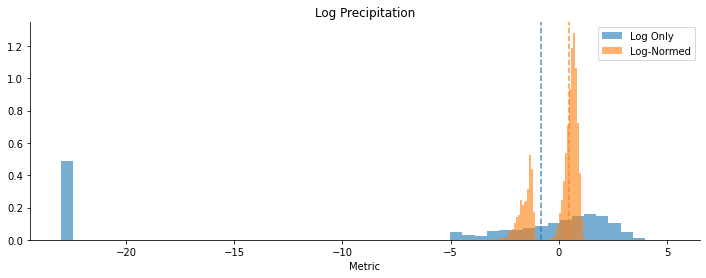

In [19]:
from scripts.cell_state.analysis import histogram_plot, finite_flat

ax = histogram_plot(finite_flat(log_pcp.values), hist_kwargs={"color": "C0", "label": "Log Only"})
histogram_plot(finite_flat(norm_log_pcp.values), ax=ax, hist_kwargs={"color": "C1", "label": "Log-Normed"})
ax.legend()
ax.set_title("Log Precipitation");

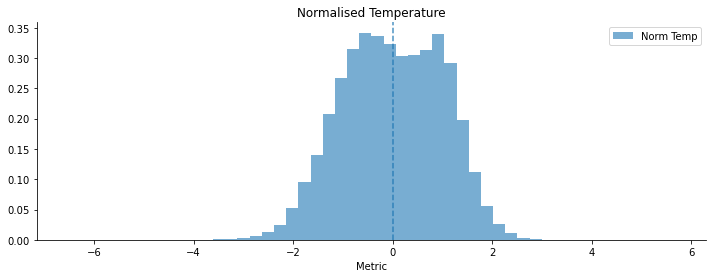

In [34]:
ax = histogram_plot(finite_flat(norm_temp.values), hist_kwargs={"color": "C0", "label": "Norm Temp"})

ax.legend()
ax.set_title("Normalised Temperature");

# Setup Data

In [35]:
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples, TimeSeriesDataset

In [36]:
input_variables = [v for v in cs.data_vars]
train_start_date = pd.to_datetime("01-01-1998")
train_end_date = pd.to_datetime("12-31-2006")
test_start_date = pd.to_datetime("01-01-2007")
test_end_date = pd.to_datetime("01-01-2009")

In [37]:
train_dataset = TimeSeriesDataset(
    input_data=cs.sel(time=slice(train_start_date, train_end_date)),
    target_data=norm_temp.sel(time=slice(train_start_date, train_end_date)),
    target_variable="temperature",
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Train Samples",
)

test_dataset = TimeSeriesDataset(
    input_data=cs.sel(time=slice(test_start_date, test_end_date)),
    target_data=norm_temp.sel(time=slice(test_start_date, test_end_date)),
    target_variable="temperature",
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Test Samples",
)

Creating Test Samples: 100%|██████████| 669/669 [00:04<00:00, 135.99it/s]


In [38]:
X, y, times, station_ids = get_time_basin_aligned_samples(train_dataset)
X_test, y_test, times_test, station_ids_test = get_time_basin_aligned_samples(test_dataset)

Extracting Data:   0%|          | 0/1908 [00:00<?, ?it/s]

Merging and reshaping arrays


Extracting Data: 100%|██████████| 1908/1908 [00:14<00:00, 130.28it/s]


Merging and reshaping arrays


# Initialise, train and evaluate model

In [39]:
from sklearn.linear_model import SGDRegressor


sgd_en = SGDRegressor(
    loss="huber",
    penalty="elasticnet",
    alpha=0.01,
    l1_ratio=0.15,            # default
    fit_intercept=True, 
    n_iter_no_change=10,
    early_stopping=True
)

In [40]:
sgd_en.fit(X, y.ravel())

SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=10,
             penalty='elasticnet')

In [41]:
y_hat = sgd_en.predict(X_test)

In [42]:
preds_sklearn = pd.DataFrame({
    "station_id": station_ids_test.ravel(),
    "time": times_test.astype("datetime64[ns]").ravel(),
    "obs": y_test.ravel(),
    "sim": y_hat.ravel(),
}).set_index(["station_id", "time"]).to_xarray()

In [43]:
y_hat_train = sgd_en.predict(X)
print("Made Predictions")

train_preds = pd.DataFrame({
    "station_id": station_ids.ravel(),
    "time": times.astype("datetime64[ns]").ravel(),
    "obs": y.ravel(),
    "sim": y_hat_train.ravel(),
}).set_index(["station_id", "time"]).to_xarray()

Made Predictions


In [44]:
from scripts.read_nh_results import calculate_all_error_metrics

errors_sklearn = calculate_all_error_metrics(
    preds_sklearn,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "Pearson-r"],
)

train_errors_sklearn = calculate_all_error_metrics(
    train_preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "Pearson-r"],
)

Calculating Errors: 100%|██████████| 669/669 [00:07<00:00, 86.36it/s, 107001]


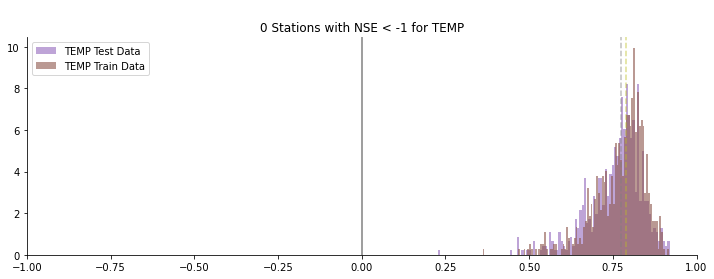

In [46]:
nse = finite_flat(errors_sklearn["NSE"])
nse_train = finite_flat(train_errors_sklearn["NSE"])
var = "TEMP"

f, ax = plt.subplots(figsize=(12, 4))

ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{var} Test Data", alpha=0.6, color="C4");
ax.axvline(nse.median(), color="C7", ls="--", alpha=0.5)

ax.hist(nse_train.where(nse_train > -1, -1), bins=100, density=True, label=f"{var} Train Data", alpha=0.6, color="C5");
ax.axvline(nse_train.median(), color="C8", ls="--", alpha=0.5)

ax.axvline(0, color="k", ls="-", alpha=0.5)
ax.set_title(f"\n{int((nse < -1).sum())} Stations with NSE < -1 for {var}")
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()